In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import cv2

## VOC 2007 & 2012 데이터셋 다운로드
- 현재 원래 제공되던 VOC 데이터셋 다운로드 사이트가 동작을 안하므로, 미러사이트에서 다운받아야한다.
- 그러나 pytorch에서 제공하는 방법은 이전 사이트에서 다운 받는 방식이기 때문에 정상적으로 실행이 되지 않는다.
- 따라서, 아래와 같은 방법으로 VOC 데이터셋을 이용할 수 있다.

1. 수동 다운로드 방법
    - VOC 2007 Train Dataset Download & Extract
        - Download
            `$ curl -L http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar >> VOCtrainval_06-Nov-2007.tar`
        - Extract
        `$ tar -xvf VOCtrainval_06-Nov-2007.tar`
    - VOC 2007 Test Dataset Download & extract
        - Download
            `$ curl -L http://pjreddie.com/media/files/VOCtest_06-Nov-2007.tar >> VOCtest_06-Nov-2007.tar`
        - Extract
            `$ tar -xvf VOCtrainval_06-Nov-2007.tar`
    - 위의 방법으로 다운로드 후,
        - `torchvision.datasets.VOCDetection`에서 `download` 인자를 `False (default)`로 하여 사용한다.
2. 새로 코드 작성
    - VOC 데이터셋의 압축 해제 후 폴더명이 train과 test가 구분이 되어 있지 않아, 이를 해소하고자 아래 코드를 새로 작성함

In [4]:
DATASET_YEAR_DICT = {
    '2012': [
        {
            'url': 'http://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar',
            'filename': 'VOCtrainval_11-May-2012.tar',
            'md5': '6cd6e144f989b92b3379bac3b3de84fd',
            'base_dir': os.path.join('VOCdevkit', 'VOC2012')
        },
        {
            'url': 'http://pjreddie.com/media/files/VOCtest_11-May-2012.tar',
            'filename': 'VOCtest_11-May-2012.tar',
            'md5': '6cd6e144f989b92b3379bac3b3de84fd',
            'base_dir': os.path.join('VOCdevkit', 'VOC2012')
        }
    ],
    '2007': [
        {
            'url': 'http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar',
            'filename': 'VOCtrainval_06-Nov-2007.tar',
            'md5': 'c52e279531787c972589f7e41ab4ae64',
            'base_dir': os.path.join('VOCdevkit', 'VOC2007')
        },
        {
            'url': 'http://pjreddie.com/media/files/VOCtest_06-Nov-2007.tar', 
            'filename': 'VOCtest_06-Nov-2007.tar', 
            'md5': 'b6e924de25625d8de591ea690078ad9f',
            'base_dir': os.path.join('VOCdevkit', 'VOC2007')
        }
    ]
}

In [5]:
import os
import tarfile
from torchvision.datasets.utils import download_and_extract_archive

class VOCDownLoader(object):
    def __init__(self, root: str, year: str, image_set: str='train'):
        self.year = year
        self.image_set = image_set

        if image_set == 'train':
            idx = 0
        elif image_set == 'test':
            idx = 1

        dataset_year_dict = DATASET_YEAR_DICT[year][idx]

        self.url = dataset_year_dict["url"]
        self.filename = dataset_year_dict["filename"]
        self.md5 = dataset_year_dict["md5"]
        
        base_dir = dataset_year_dict["base_dir"]

        self.root = os.path.join(root, 'VOC', year, image_set)
        if not os.path.isdir(self.root):
            os.makedirs(self.root, exist_ok=True)
        voc_file = os.path.join(self.root, self.filename)
        print(voc_file)
        if not os.path.exists(voc_file):
            download_and_extract_archive(self.url, self.root, filename=self.filename, md5=self.md5)
        else:
            base_dir = base_dir.split('/')
            self.voc_root = os.path.join(self.root, base_dir[0])
            if not os.path.exists(self.voc_root):
                ap = tarfile.open(voc_file)
                ap.extractall(self.root)
                ap.close()
                print('Extracting complete')
            print('Files already downloaded')

In [6]:
train = VOCDownLoader(root='./data', year='2007', image_set='train')
train.root, train.year, train.image_set

Files already downloaded


('./data/VOC/2007/train', '2007', 'train')

In [7]:
pre_processing = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [8]:
_dataset = datasets.VOCDetection(root=train.root, year=train.year, image_set=train.image_set, transform=pre_processing)

- 다운 받은 데이터를 train과 valid data로 스플릿
    > `image_set='train'`: train + valid 용 데이터
    > `image_set='test'`: test 용 데이터

In [9]:
train_len = int(len(_dataset) * 0.8)
valid_len = int(len(_dataset) * 0.2) + 1
train_data, valid_data = torch.utils.data.random_split(_dataset, [train_len, valid_len])

### Data 확인

In [10]:
img, target = train_data[0]

In [11]:
target

{'annotation': {'folder': 'VOC2007',
  'filename': '005960.jpg',
  'source': {'database': 'The VOC2007 Database',
   'annotation': 'PASCAL VOC2007',
   'image': 'flickr',
   'flickrid': '300943002'},
  'owner': {'flickrid': 'amieandkelly', 'name': '?'},
  'size': {'width': '500', 'height': '375', 'depth': '3'},
  'segmented': '0',
  'object': [{'name': 'cat',
    'pose': 'Frontal',
    'truncated': '0',
    'difficult': '0',
    'bndbox': {'xmin': '94', 'ymin': '284', 'xmax': '166', 'ymax': '370'}}]}}

In [12]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    img = np.transpose(npimg, (1, 2, 0))
    return img

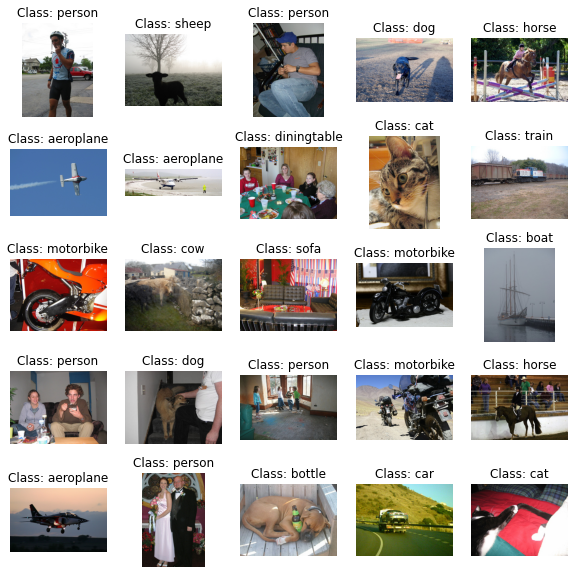

In [13]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    image, target = train_data[sample_idx]
    label = target['annotation']['object'][0]['name']
    plt.subplot(cols, rows, i)
    img = imshow(image)
    plt.imshow(img)
    plt.title(f'Class: {label}')
    plt.axis("off")
plt.show()

## Bounding box 그리기

In [40]:
base_img, target = train_data[10]
base_img.size, target

(<function Tensor.size>,
 {'annotation': {'folder': 'VOC2007',
   'filename': '003396.jpg',
   'source': {'database': 'The VOC2007 Database',
    'annotation': 'PASCAL VOC2007',
    'image': 'flickr',
    'flickrid': '332285864'},
   'owner': {'flickrid': 'PressPix Photography', 'name': 'Mike Philippens'},
   'size': {'width': '500', 'height': '344', 'depth': '3'},
   'segmented': '0',
   'object': [{'name': 'motorbike',
     'pose': 'Unspecified',
     'truncated': '1',
     'difficult': '0',
     'bndbox': {'xmin': '14', 'ymin': '84', 'xmax': '376', 'ymax': '330'}},
    {'name': 'motorbike',
     'pose': 'Unspecified',
     'truncated': '1',
     'difficult': '0',
     'bndbox': {'xmin': '192', 'ymin': '75', 'xmax': '387', 'ymax': '330'}},
    {'name': 'person',
     'pose': 'Unspecified',
     'truncated': '0',
     'difficult': '0',
     'bndbox': {'xmin': '124', 'ymin': '50', 'xmax': '371', 'ymax': '279'}},
    {'name': 'person',
     'pose': 'Unspecified',
     'truncated': '1',


In [41]:
target['annotation']['object']

[{'name': 'motorbike',
  'pose': 'Unspecified',
  'truncated': '1',
  'difficult': '0',
  'bndbox': {'xmin': '14', 'ymin': '84', 'xmax': '376', 'ymax': '330'}},
 {'name': 'motorbike',
  'pose': 'Unspecified',
  'truncated': '1',
  'difficult': '0',
  'bndbox': {'xmin': '192', 'ymin': '75', 'xmax': '387', 'ymax': '330'}},
 {'name': 'person',
  'pose': 'Unspecified',
  'truncated': '0',
  'difficult': '0',
  'bndbox': {'xmin': '124', 'ymin': '50', 'xmax': '371', 'ymax': '279'}},
 {'name': 'person',
  'pose': 'Unspecified',
  'truncated': '1',
  'difficult': '0',
  'bndbox': {'xmin': '287', 'ymin': '37', 'xmax': '427', 'ymax': '164'}}]

In [42]:
len(target['annotation']['object'])

4

In [43]:
obj = {}

In [44]:
for i in range(len(target['annotation']['object'])):
    name = target['annotation']['object'][i]['name']
    bbox = target['annotation']['object'][i]['bndbox']
    for key, val in bbox.items():
        bbox[key] = int(val)
    obj[i] = [name, bbox]

obj

{0: ['motorbike', {'xmin': 14, 'ymin': 84, 'xmax': 376, 'ymax': 330}],
 1: ['motorbike', {'xmin': 192, 'ymin': 75, 'xmax': 387, 'ymax': 330}],
 2: ['person', {'xmin': 124, 'ymin': 50, 'xmax': 371, 'ymax': 279}],
 3: ['person', {'xmin': 287, 'ymin': 37, 'xmax': 427, 'ymax': 164}]}

In [45]:
base_img = imshow(base_img)
base_img.shape

(344, 500, 3)

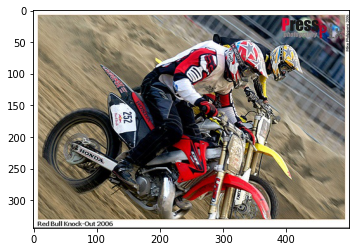

In [46]:
plt.imshow(base_img)

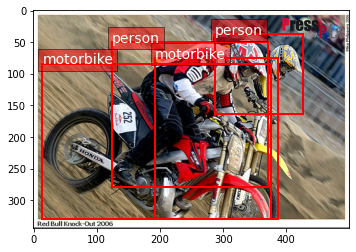

In [47]:
import matplotlib, cv2

fig, ax = plt.subplots(1)
ax.imshow(base_img)
for i in range(len(obj)):
    xmin = obj[i][1]['xmin']
    ymin = obj[i][1]['ymin']
    xmax = obj[i][1]['xmax']
    ymax = obj[i][1]['ymax']

    bbox = matplotlib.patches.Rectangle(xy=(xmin, ymin), width=(xmax-xmin), height=(ymax-ymin), linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(bbox)
    ax.text(xmin, ymin, obj[i][0], size=14, color='white', bbox=dict(facecolor='red', alpha=0.5))
#plt.title(f'Class: {label}')
#plt.show()